In [1]:
#Importing Libraries
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import ast
plt.rcParams["font.family"] = "Arial"

#Loading Data
dataset= load_dataset('lukebarousse/data_jobs')
df= dataset['train'].to_pandas()

#Data Cleaning
df['job_posted_date']= pd.to_datetime(df['job_posted_date'])
df['job_skills']= df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
df_da_us= df[(df['job_title_short']== 'Data Analyst') & (df['job_country']== 'United States')].copy()

In [3]:
df_da_us= df_da_us.dropna(subset='salary_year_avg')
df_da_us_explode= df_da_us.explode('job_skills')
df_da_us_explode.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
109,Data Analyst,Senior Supply Chain Analytics Analyst,Anywhere,via Get.It,Full-time,True,"Illinois, United States",2023-10-12 13:02:19,False,True,United States,year,89000.0,NaN,Get It Recruit - Transportation,python,"{'analyst_tools': ['alteryx', 'tableau'], 'pro..."
109,Data Analyst,Senior Supply Chain Analytics Analyst,Anywhere,via Get.It,Full-time,True,"Illinois, United States",2023-10-12 13:02:19,False,True,United States,year,89000.0,NaN,Get It Recruit - Transportation,r,"{'analyst_tools': ['alteryx', 'tableau'], 'pro..."
109,Data Analyst,Senior Supply Chain Analytics Analyst,Anywhere,via Get.It,Full-time,True,"Illinois, United States",2023-10-12 13:02:19,False,True,United States,year,89000.0,NaN,Get It Recruit - Transportation,alteryx,"{'analyst_tools': ['alteryx', 'tableau'], 'pro..."
109,Data Analyst,Senior Supply Chain Analytics Analyst,Anywhere,via Get.It,Full-time,True,"Illinois, United States",2023-10-12 13:02:19,False,True,United States,year,89000.0,NaN,Get It Recruit - Transportation,tableau,"{'analyst_tools': ['alteryx', 'tableau'], 'pro..."
180,Data Analyst,Data Analyst III,"Dos Palos, CA",via My ArkLaMiss Jobs,Full-time,False,"California, United States",2023-02-27 13:00:39,False,True,United States,year,90250.0,NaN,California Health & Wellness,excel,"{'analyst_tools': ['excel', 'powerpoint']}"


In [4]:
df_da_skills=df_da_us_explode.groupby('job_skills').agg(skill_count=('job_skills', 'size'),
                                           median_salary=('salary_year_avg', 'median')).sort_values(by='skill_count', ascending=False)

da_job_count= len(df_da_us)
df_da_skills['skills_percent']= df_da_skills['skill_count'] / da_job_count*100
skill_percent= 5
df_da_skills_high_demand= df_da_skills[df_da_skills['skills_percent']> skill_percent]
df_da_skills_high_demand

,skill_count,median_salary,skills_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


In [6]:
df_technology= df['job_type_skills'].copy()
df_technology= df_technology.drop_duplicates()
df_technology= df_technology.dropna()
df_technology.head()

1    {'analyst_tools': ['power bi', 'tableau'], 'pr...
2    {'analyst_tools': ['dax'], 'cloud': ['azure'],...
3    {'cloud': ['aws'], 'libraries': ['tensorflow',...
4    {'cloud': ['oracle', 'aws'], 'other': ['ansibl...
5    {'cloud': ['gcp'], 'programming': ['python', '...
Name: job_type_skills, dtype: object

In [7]:
technology_dict= {}
for row in df_technology:
    row_dict= ast.literal_eval(row)
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value
    

In [8]:
for key, value in technology_dict.items():
    technology_dict[key]= list(set(value))

In [12]:
df_technology=pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])
df_technology= df_technology.explode('skills')
df_technology

,technology,skills
0,analyst_tools,excel
0,analyst_tools,ssrs
0,analyst_tools,sas
0,analyst_tools,cognos
0,analyst_tools,spreadsheet
...,...,...
9,sync,wire
9,sync,ringcentral
9,sync,microsoft teams
9,sync,unify


In [17]:
df_plot= df_da_skills_high_demand.merge(df_technology, left_on='job_skills', right_on='skills')
df_plot

,skill_count,median_salary,skills_percent,technology,skills
0,2508,91000.00,57.655172,programming,sql
1,1808,84392.00,41.563218,analyst_tools,excel
2,1431,97500.00,32.896552,programming,python
3,1364,92875.00,31.356322,analyst_tools,tableau
4,926,90000.00,21.287356,analyst_tools,sas
5,926,90000.00,21.287356,programming,sas
6,893,92500.00,20.528736,programming,r
7,838,90000.00,19.264368,analyst_tools,power bi
8,462,85000.00,10.620690,analyst_tools,powerpoint
9,461,81194.75,10.597701,analyst_tools,word


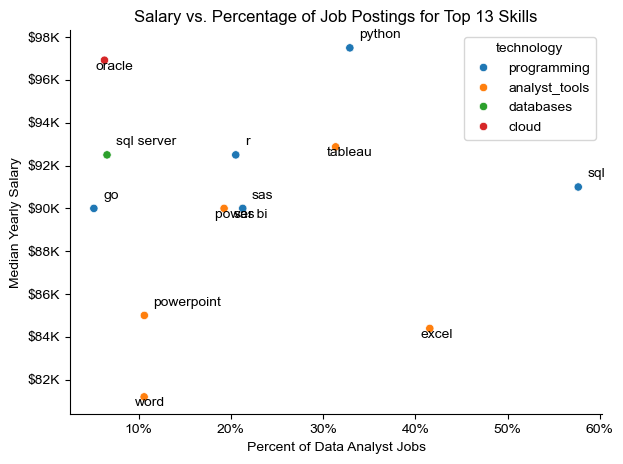

In [23]:
from matplotlib.ticker import PercentFormatter

sns.scatterplot(data=df_plot, x='skills_percent', y='median_salary', hue='technology')
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title(f'Salary vs. Percentage of Job Postings for Top {len(df_plot)} Skills')

for i, skill in enumerate(df_plot.skills):
    if i%2==0:
        plt.text(df_plot['skills_percent'].iloc[i]+1, df_plot['median_salary'].iloc[i]+450, skill)
    else:
        plt.text(df_plot['skills_percent'].iloc[i]-1, df_plot['median_salary'].iloc[i]-450, skill)
        
ax= plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${y/1000:1.0f}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
sns.despine()
sns.set_theme(style='ticks')
plt.tight_layout()
plt.show()